### Réduction des dimenssions

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [9]:
%%time 
import gensim
import gensim.corpora as corpora
from gensim import models
from gensim.utils import simple_preprocess
from gensim.models.ldamulticore import LdaMulticore
from gensim.models import CoherenceModel
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)


def compute_coherence_values(dictionary, corpus, texts, limit, mallet=False, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Args:
  
        dictionary : Gensim dictionary
        corpus : Gensim corpus
        texts : List of input texts
        limit : Max num of topics

    Returns:
    
        model_list : List of LDA topic models
        coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    
    
    for num_topics in range(start, limit, step):
        
        if mallet == True:
            model = gensim.models.wrappers.LdaMallet(mallet_path = mallet_path, 
                                                     corpus=corpus, num_topics=num_topics, 
                                                     id2word=id2word, 
                                                     prefix='temp_file_',
                                                     workers=3)
        
        else:
            model = LdaMulticore(corpus=corpus,
                                id2word=dictionary,
                                num_topics=num_topics, 
                                random_state=42,
                                chunksize=100,
                                passes=10,
                                workers=7)

        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

#model_list, coherence_values = compute_coherence_values(mallet=False, dictionary=id2word, corpus=corpus_tfidf, texts=texts, start=2, limit=51, step=1)

CPU times: user 32 µs, sys: 4 µs, total: 36 µs
Wall time: 36.2 µs


In [3]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


# df_topic_sents_keywords = format_topics_sentences(ldamodel=lda, corpus=corpus_tfidf, texts=html_cleaned_texts)

# # Format
# df_dominant_topic = df_topic_sents_keywords.reset_index()
# df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# # Show
# df_dominant_topic.head(10)

### Avec bigrammes lematizés

In [ ]:
%%time
import spacy
nlp = spacy.load('en_core_web_sm',disable=['parser', 'ner'])

data = filtered_data['tokenized_post'].values.tolist()

bigram = gensim.models.Phrases(data, min_count=1000, threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)

data_bigrams = [bigram_mod[doc] for doc in data]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

bigrams_data = make_bigrams(data)
lemmatized_data = lemmatization(bigrams_data, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

id2word = corpora.Dictionary(lemmatized_data)
corpus = [id2word.doc2bow(text) for text in texts] 
bow_corpus = [id2word.doc2bow(text) for text in texts]

model_list, coherence_values = compute_coherence_values(mallet=False, dictionary=id2word, corpus=bow_corpus, texts=lemmatized_data, start=2, limit=51, step=1)

limit=51; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

In [ ]:
%%time
from pprint import pprint
optimal_model = model_list[9]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

In [ ]:
%%time
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=bow_corpus, texts=html_cleaned_texts)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

In [ ]:
print("Publication du premier document\n")
display(df_dominant_topic.loc[0,'Text'])
print("\n")
print(f"Numéro du topic: {df_dominant_topic.loc[0,'Dominant_Topic']}")
print("\n")
print("Mots clés associés\n")
display(df_dominant_topic.loc[0,'Keywords'])

In [ ]:
sent_topics_sorteddf = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf = pd.concat([sent_topics_sorteddf, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf

In [ ]:
for index, row in sent_topics_sorteddf.iterrows():
    print(f"Numéro du topic: {row['Topic_Num']}")
    print("\n")
    print("Mots clés associes au topic:\n")
    print(f"{row['Keywords']}")
    print("\n")
    print("Publication la plus significative du topic:")
    print("\n")
    print(f"{row['Text']}")
    print("\n")
    print("=" * 50)

In [ ]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = sent_topics_sorteddf[["Topic_Num","Keywords"]]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

In [ ]:
%%time

from IPython.display import HTML
css_str = '<style> \
.jp-icon-warn0 path {fill: var(--jp-warn-color0);} \
.bp3-button-text path { fill: var(--jp-inverse-layout-color3);} \
.jp-icon-brand0 path { fill: var(--jp-brand-color0);} \
text.terms { fill: #616161;} \
</style>'
display(HTML(css_str))

import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(optimal_model, bow_corpus, id2word)
pyLDAvis.save_html(vis, 'lda_imported_data.html')
display(HTML('lda_imported_data.html'))

## Avec données importées

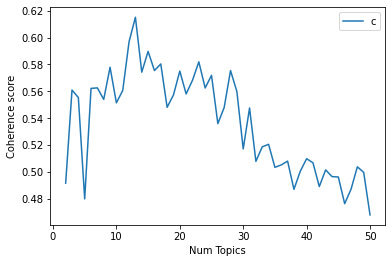

Num Topics = 2  has Coherence Value of 0.4916
Num Topics = 3  has Coherence Value of 0.5609
Num Topics = 4  has Coherence Value of 0.5554
Num Topics = 5  has Coherence Value of 0.4799
Num Topics = 6  has Coherence Value of 0.5622
Num Topics = 7  has Coherence Value of 0.5625
Num Topics = 8  has Coherence Value of 0.554
Num Topics = 9  has Coherence Value of 0.5779
Num Topics = 10  has Coherence Value of 0.5514
Num Topics = 11  has Coherence Value of 0.5606
Num Topics = 12  has Coherence Value of 0.597
Num Topics = 13  has Coherence Value of 0.6152
Num Topics = 14  has Coherence Value of 0.5743
Num Topics = 15  has Coherence Value of 0.5897
Num Topics = 16  has Coherence Value of 0.5754
Num Topics = 17  has Coherence Value of 0.5804
Num Topics = 18  has Coherence Value of 0.5481
Num Topics = 19  has Coherence Value of 0.5573
Num Topics = 20  has Coherence Value of 0.5751
Num Topics = 21  has Coherence Value of 0.558
Num Topics = 22  has Coherence Value of 0.5682
Num Topics = 23  has Coh

In [10]:
%%time
from sklearn.model_selection import train_test_split

data = pd.read_pickle("./data/cleaned_corpus.pkl")
texts = data['splitted_text'].to_list()
id2word = corpora.Dictionary(texts) 
bow_corpus = [id2word.doc2bow(text) for text in texts]

model_list, coherence_values = compute_coherence_values(mallet=False, dictionary=id2word, corpus=bow_corpus, texts=texts, start=2, limit=51, step=1)

limit=51; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

In [11]:
%%time
from pprint import pprint
optimal_model = model_list[12]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.071*"date" + 0.067*"node" + 0.045*"module" + 0.042*"json" + 0.025*"error" '
  '+ 0.024*"webpack" + 0.023*"plugin" + 0.021*"config" + 0.020*"index" + '
  '0.019*"loader"'),
 (1,
  '0.095*"name" + 0.064*"value" + 0.043*"class" + 0.042*"type" + '
  '0.026*"string" + 0.017*"return" + 0.017*"list" + 0.016*"group" + '
  '0.014*"service" + 0.014*"field"'),
 (2,
  '0.389*"java" + 0.069*"apache" + 0.036*"lang" + 0.026*"method" + '
  '0.025*"base" + 0.016*"invoke" + 0.014*"catalina" + 0.012*"class" + '
  '0.012*"source" + 0.010*"handler"'),
 (3,
  '0.078*"flutter" + 0.043*"package" + 0.041*"dart" + 0.037*"child" + '
  '0.034*"context" + 0.024*"widget" + 0.021*"return" + 0.015*"channel" + '
  '0.014*"builder" + 0.013*"title"'),
 (4,
  '0.068*"spring" + 0.063*"springframework" + 0.056*"release" + 0.043*"boot" + '
  '0.038*"core" + 0.031*"dependency" + 0.028*"version" + 0.022*"info" + '
  '0.019*"artifactid" + 0.018*"class"'),
 (5,
  '0.056*"execution" + 0.039*"java" + 0.036*"execute" + 0

In [12]:
%%time
original_posts = data['Post'].to_list()
original_cleaned_keywords = data['splitted_tags']
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=bow_corpus, texts=original_posts)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic = pd.concat([df_dominant_topic, original_cleaned_keywords], axis=1)
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text', 'Original_keywords']

# Show
df_dominant_topic.head(10)

CPU times: user 3min 57s, sys: 0 ns, total: 3min 57s
Wall time: 3min 56s


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,Original_keywords
0,0.0,11.0,0.5332,"error, version, system, project, code, program...",Can (a== 1 && a ==2 && a==3) ever evaluate to ...,"[javascript, ecmascript]"
1,1.0,11.0,0.6175,"error, version, system, project, code, program...",Git is not working after macOS Update (xcrun: ...,"[xcode, macos, command, line, terminal]"
2,2.0,11.0,0.7571,"error, version, system, project, code, program...",Why is 2 * (i * i) faster than 2 * i * i in Ja...,"[java, performance, benchmarking, bytecode]"
3,3.0,11.0,0.9525,"error, version, system, project, code, program...",Xcode 10 Error: Multiple commands produce <blo...,"[info, plist, xcode]"
4,4.0,10.0,0.3359,"model, column, size, print, input, list, array...","Why does array[idx++]+=""a"" increase idx once i...","[java, java, javac, java, java]"
5,5.0,11.0,0.5113,"error, version, system, project, code, program...",Difference between npx and npm? <p>I have just...,[javascript]
6,6.0,11.0,0.8690,"error, version, system, project, code, program...",Cannot inline bytecode built with JVM target 1...,"[android, intellij, idea, kotlin, corda]"
7,7.0,8.0,0.4841,"import, component, const, react, export, funct...","Could not find module ""@angular-devkit/build-a...","[angular, angular, angular, angular]"
8,8.0,0.0,0.5752,"date, node, module, json, error, webpack, plug...","How to fix ""ReferenceError: primordials is not...","[node, sas, gulp, gulp, sas]"
9,9.0,13.0,0.9226,"class, button, text, form, item, color, input,...",Why is the result of ('b'+'a'+ + 'a' + 'a').to...,"[javascript, type, conversion]"


In [13]:
print("Publication du premier document\n")
display(df_dominant_topic.loc[0,'Text'])
print("\n")
print(f"Numéro du topic: {df_dominant_topic.loc[0,'Dominant_Topic']}")
print("\n")
print("Mots clés associés\n")
display(df_dominant_topic.loc[0,'Keywords'])
print("\n")
print("Mots clés originaux")
display(df_dominant_topic.loc[0, 'Original_keywords'])

Publication du premier document



'Can (a== 1 && a ==2 && a==3) ever evaluate to true? <blockquote>\n  <p><strong>Moderator note:</strong> Please resist the urge to edit the code or remove this notice. The pattern of whitespace may be part of the question and therefore should not be tampered with unnecessarily. If you are in the "whitespace is insignificant" camp, you should be able to accept the code as is.</p>\n</blockquote>\n\n<p>Is it ever possible that <code>(a== 1 &amp;&amp; a ==2 &amp;&amp; a==3)</code> could evaluate to <code>true</code> in JavaScript?</p>\n\n<p>This is an interview question asked by a major tech company. It happened two weeks back, but I\'m still trying to find the answer. I know we never write such code in our day-to-day job, but I\'m curious.</p>\n'



Numéro du topic: 11.0


Mots clés associés



'error, version, system, project, code, program, problem, application, http, file'



Mots clés originaux


['javascript', 'ecmascript']

In [14]:
sent_topics_sorteddf = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf = pd.concat([sent_topics_sorteddf, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.9690,"date, node, module, json, error, webpack, plug...",Webpack - Cannot find module raw-loader <p>I n...
1,1.0,0.9799,"name, value, class, type, string, return, list...","How to fix TS2322: ""could be instantiated with..."
2,2.0,0.8832,"java, apache, lang, method, base, invoke, cata...",FindBugs IDEA - ClassNotFoundException com.goo...
3,3.0,0.9784,"flutter, package, dart, child, context, widget...",incorrect use of parent data widget. expanded ...
4,4.0,0.9810,"spring, springframework, release, boot, core, ...",Validate failed: Detected applied migration no...
5,5.0,0.8687,"execution, java, execute, cell, plot, frame, f...",Error on gradle task ':app:compileDebugJavaWit...
6,6.0,0.9946,"google, android, implementation, firebase, sup...",Failed to resolve variable '${animal.sniffer.v...
7,7.0,0.9909,"file, python, line, docker, error, site, image...",How to fix -- bash: /usr/bin/python: Too many ...
8,8.0,0.9700,"import, component, const, react, export, funct...",Angular 4 - Failed: Can't resolve all paramete...
9,9.0,0.9698,"view, android, layout, parent, batch, shape, n...",Bottom Navigation with fab <p>I am currently w...


In [15]:
for index, row in sent_topics_sorteddf.iterrows():
    print(f"Numéro du topic: {row['Topic_Num']}")
    print("\n")
    print("Mots clés associes au topic:\n")
    print(f"{row['Keywords']}")
    print("\n")
    print("Publication la plus significative du topic:")
    print("\n")
    print(f"{row['Text']}")
    print("\n")
    print("=" * 50)

Numéro du topic: 0.0


Mots clés associes au topic:

date, node, module, json, error, webpack, plugin, config, index, loader


Publication la plus significative du topic:


Webpack - Cannot find module raw-loader <p>I need to load a JS file as a string so I can run some analysis on it. I am trying to use raw-loader with Webpack (2.2.0).</p>

<p>I get:  <code>Cannot find module 'raw-loader!../</code> </p>

<p>I've tried (yes, the path is correct):</p>

<pre><code>let app = require('raw-loader!../../app.js').default;

let app = require('!!raw-loader!../../app.js').default;
</code></pre>

<p>I've even tried it without inline. Raw-loader doesn't get engaged, it just tried to load the JS file normally:</p>

<pre><code>module.exports = {
  module: {
    rules: [
      {
        test: /\app.js$/i,
        use: 'raw-loader',
        loader: 'raw-loader',
      }
    ]
  }
}
</code></pre>

<p>raw-loader is in my package.json for the project. It is present in my node modules. I've blown-away my 

In [16]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = sent_topics_sorteddf[["Topic_Num","Keywords"]]

# Concatenate Column wise
df_dominant_topics_prop = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics_prop.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics_prop

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,0.0,"date, node, module, json, error, webpack, plug...",1695,0.0369
1.0,1.0,"name, value, class, type, string, return, list...",3889,0.0847
2.0,2.0,"java, apache, lang, method, base, invoke, cata...",526,0.0115
3.0,3.0,"flutter, package, dart, child, context, widget...",1178,0.0257
4.0,4.0,"spring, springframework, release, boot, core, ...",1184,0.0258
5.0,5.0,"execution, java, execute, cell, plot, frame, f...",151,0.0033
6.0,6.0,"google, android, implementation, firebase, sup...",1288,0.0281
7.0,7.0,"file, python, line, docker, error, site, image...",6499,0.1416
8.0,8.0,"import, component, const, react, export, funct...",3662,0.0798
9.0,9.0,"view, android, layout, parent, batch, shape, n...",678,0.0148


In [17]:
%%time

from IPython.display import HTML
css_str = '<style> \
.jp-icon-warn0 path {fill: var(--jp-warn-color0);} \
.bp3-button-text path { fill: var(--jp-inverse-layout-color3);} \
.jp-icon-brand0 path { fill: var(--jp-brand-color0);} \
text.terms { fill: #616161;} \
</style>'
display(HTML(css_str))

import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(optimal_model, bow_corpus, id2word)
pyLDAvis.save_html(vis, 'lda_imported_data.html')
display(HTML('lda_imported_data.html'))

CPU times: user 9.02 s, sys: 1.08 s, total: 10.1 s
Wall time: 10.7 s


### Avec tf-idf

/home/cedric/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


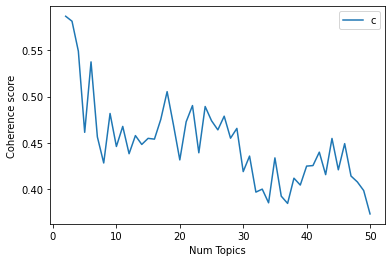

Num Topics = 2  has Coherence Value of 0.5868
Num Topics = 3  has Coherence Value of 0.5814
Num Topics = 4  has Coherence Value of 0.5491
Num Topics = 5  has Coherence Value of 0.4613
Num Topics = 6  has Coherence Value of 0.5374
Num Topics = 7  has Coherence Value of 0.4563
Num Topics = 8  has Coherence Value of 0.4282
Num Topics = 9  has Coherence Value of 0.4817
Num Topics = 10  has Coherence Value of 0.446
Num Topics = 11  has Coherence Value of 0.4677
Num Topics = 12  has Coherence Value of 0.4381
Num Topics = 13  has Coherence Value of 0.4578
Num Topics = 14  has Coherence Value of 0.4482
Num Topics = 15  has Coherence Value of 0.4548
Num Topics = 16  has Coherence Value of 0.4539
Num Topics = 17  has Coherence Value of 0.4753
Num Topics = 18  has Coherence Value of 0.5053
Num Topics = 19  has Coherence Value of 0.4693
Num Topics = 20  has Coherence Value of 0.4315
Num Topics = 21  has Coherence Value of 0.4726
Num Topics = 22  has Coherence Value of 0.4902
Num Topics = 23  has C

In [34]:
%%time

from gensim.models import TfidfModel
data = pd.read_pickle("./data/cleaned_corpus.pkl")
texts = data['splitted_text'].to_list()
id2word = corpora.Dictionary(texts)
bow_corpus = [id2word.doc2bow(text) for text in texts]
tfidf = TfidfModel(bow_corpus)
tfidf_corpus = [tfidf[text] for text in bow_corpus]

model_list, coherence_values = compute_coherence_values(mallet=False, dictionary=id2word, corpus=tfidf_corpus, texts=texts, start=2, limit=51, step=1)

limit=51; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

In [35]:
%%time
from pprint import pprint
optimal_model = model_list[2]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.005*"file" + 0.004*"error" + 0.004*"name" + 0.004*"python" + '
  '0.004*"import" + 0.004*"function" + 0.003*"value" + 0.003*"json" + '
  '0.003*"code" + 0.003*"version"'),
 (1,
  '0.001*"cypress" + 0.001*"myclass" + 0.001*"telegram" + '
  '0.001*"defaultbuildoperationexecutor" + 0.000*"pyaudio" + 0.000*"jacoco" + '
  '0.000*"phpspreadsheet" + 0.000*"mybase" + 0.000*"myvar" + 0.000*"heatmap"'),
 (2,
  '0.002*"pyspark" + 0.002*"employee" + 0.002*"unity" + 0.002*"scala" + '
  '0.002*"ingres" + 0.001*"tomcat" + 0.001*"helm" + 0.001*"spark" + '
  '0.001*"resttemplate" + 0.001*"kubelet"'),
 (3,
  '0.006*"button" + 0.006*"color" + 0.005*"class" + 0.004*"view" + '
  '0.004*"style" + 0.003*"item" + 0.003*"text" + 0.003*"component" + '
  '0.003*"form" + 0.003*"springframework"')]
CPU times: user 7.98 ms, sys: 1.06 ms, total: 9.03 ms
Wall time: 6.94 ms


/home/cedric/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [36]:
%%time
original_posts = data['Post'].to_list()
original_cleaned_keywords = data['splitted_tags']
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=tfidf_corpus, texts=original_posts)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic = pd.concat([df_dominant_topic, original_cleaned_keywords], axis=1)
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text', 'Original_keywords']

# Show
df_dominant_topic.head(10)

/home/cedric/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


CPU times: user 2min 22s, sys: 0 ns, total: 2min 22s
Wall time: 2min 22s


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,Original_keywords
0,0.0,0.0,0.8449,"file, error, name, python, import, function, v...",Can (a== 1 && a ==2 && a==3) ever evaluate to ...,"[javascript, ecmascript]"
1,1.0,0.0,0.7936,"file, error, name, python, import, function, v...",Git is not working after macOS Update (xcrun: ...,"[xcode, macos, command, line, terminal]"
2,2.0,0.0,0.8023,"file, error, name, python, import, function, v...",Why is 2 * (i * i) faster than 2 * i * i in Ja...,"[java, performance, benchmarking, bytecode]"
3,3.0,0.0,0.8033,"file, error, name, python, import, function, v...",Xcode 10 Error: Multiple commands produce <blo...,"[info, plist, xcode]"
4,4.0,0.0,0.8715,"file, error, name, python, import, function, v...","Why does array[idx++]+=""a"" increase idx once i...","[java, java, javac, java, java]"
5,5.0,0.0,0.8039,"file, error, name, python, import, function, v...",Difference between npx and npm? <p>I have just...,[javascript]
6,6.0,0.0,0.7335,"file, error, name, python, import, function, v...",Cannot inline bytecode built with JVM target 1...,"[android, intellij, idea, kotlin, corda]"
7,7.0,0.0,0.8651,"file, error, name, python, import, function, v...","Could not find module ""@angular-devkit/build-a...","[angular, angular, angular, angular]"
8,8.0,0.0,0.8317,"file, error, name, python, import, function, v...","How to fix ""ReferenceError: primordials is not...","[node, sas, gulp, gulp, sas]"
9,9.0,0.0,0.5937,"file, error, name, python, import, function, v...",Why is the result of ('b'+'a'+ + 'a' + 'a').to...,"[javascript, type, conversion]"


In [37]:
print("Publication du premier document\n")
display(df_dominant_topic.loc[0,'Text'])
print("\n")
print(f"Numéro du topic: {df_dominant_topic.loc[0,'Dominant_Topic']}")
print("\n")
print("Mots clés associés\n")
display(df_dominant_topic.loc[0,'Keywords'])
print("\n")
print("Mots clés originaux")
display(df_dominant_topic.loc[0, 'Original_keywords'])

Publication du premier document



/home/cedric/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'Can (a== 1 && a ==2 && a==3) ever evaluate to true? <blockquote>\n  <p><strong>Moderator note:</strong> Please resist the urge to edit the code or remove this notice. The pattern of whitespace may be part of the question and therefore should not be tampered with unnecessarily. If you are in the "whitespace is insignificant" camp, you should be able to accept the code as is.</p>\n</blockquote>\n\n<p>Is it ever possible that <code>(a== 1 &amp;&amp; a ==2 &amp;&amp; a==3)</code> could evaluate to <code>true</code> in JavaScript?</p>\n\n<p>This is an interview question asked by a major tech company. It happened two weeks back, but I\'m still trying to find the answer. I know we never write such code in our day-to-day job, but I\'m curious.</p>\n'



Numéro du topic: 0.0


Mots clés associés



'file, error, name, python, import, function, value, json, code, version'



Mots clés originaux


['javascript', 'ecmascript']

In [38]:
sent_topics_sorteddf = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf = pd.concat([sent_topics_sorteddf, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf

/home/cedric/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.9433,"file, error, name, python, import, function, v...",Sudden Tensorflow / Keras Google Colab depende...
1,1.0,0.9535,"cypress, myclass, telegram, defaultbuildoperat...",InvalidCharacterError: String contains an inva...
2,2.0,0.8717,"pyspark, employee, unity, scala, ingres, tomca...",Encode Private Key getting Error: asn1: struct...
3,3.0,0.9095,"button, color, class, view, style, item, text,...",Keep the bottom navigation bar in every screen...


Numéro du topic: 0.0


Mots clés associes au topic:

file, error, name, python, import, function, value, json, code, version


Publication la plus significative du topic:


Sudden Tensorflow / Keras Google Colab dependency problems `AttributeError: module 'tensorflow._api.v1.compat.v2' has no attribute '__internal__'` <p>I have running a machine learning model (Matterport's Mask R-CNN) in google colab for a couple of weeks.  All of a sudden today I am unable to run any of my notebooks due to I think some kind of dependency mismatch error.  The full error is as follows:</p>
<pre><code>---------------------------------------------------------------------------
AttributeError                            Traceback (most recent call last)
&lt;ipython-input-3-d76d39ae81e5&gt; in &lt;module&gt;()
     11 
     12 import tensorflow as tf
---&gt; 13 import keras
     14 import platform
     15 

8 frames
/usr/local/lib/python3.7/dist-packages/keras/__init__.py in &lt;module&gt;()
      1 from __
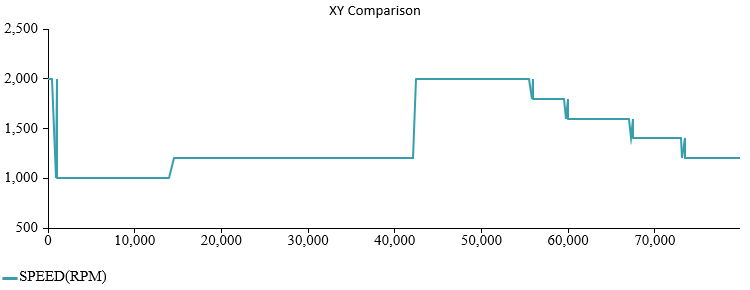

/home/cedric/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [39]:
for index, row in sent_topics_sorteddf.iterrows():
    print(f"Numéro du topic: {row['Topic_Num']}")
    print("\n")
    print("Mots clés associes au topic:\n")
    print(f"{row['Keywords']}")
    print("\n")
    print("Publication la plus significative du topic:")
    print("\n")
    print(f"{row['Text']}")
    print("\n")
    print("=" * 50)

In [40]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = sent_topics_sorteddf[["Topic_Num","Keywords"]]

# Concatenate Column wise
df_dominant_topics_prop = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics_prop.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics_prop

/home/cedric/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,0.0,"file, error, name, python, import, function, v...",38031,0.8285
1.0,1.0,"cypress, myclass, telegram, defaultbuildoperat...",238,0.0052
2.0,2.0,"pyspark, employee, unity, scala, ingres, tomca...",313,0.0068
3.0,3.0,"button, color, class, view, style, item, text,...",7320,0.1595


In [41]:
%%time

from IPython.display import HTML
css_str = '<style> \
.jp-icon-warn0 path {fill: var(--jp-warn-color0);} \
.bp3-button-text path { fill: var(--jp-inverse-layout-color3);} \
.jp-icon-brand0 path { fill: var(--jp-brand-color0);} \
text.terms { fill: #616161;} \
</style>'
display(HTML(css_str))

import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(optimal_model, bow_corpus, id2word)
pyLDAvis.save_html(vis, 'lda_imported_data_tfidf.html')
display(HTML('lda_imported_data_tfidf.html'))

/home/cedric/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


CPU times: user 5.42 s, sys: 0 ns, total: 5.42 s
Wall time: 6.34 s


### Avec un dictionary ne contenant que les mots ayant plus de 1000 occurences

/home/cedric/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


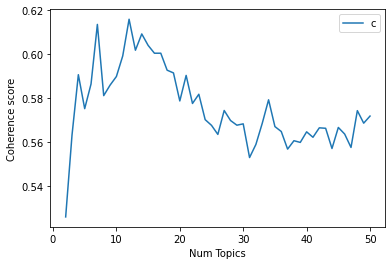

Num Topics = 2  has Coherence Value of 0.5261
Num Topics = 3  has Coherence Value of 0.5633
Num Topics = 4  has Coherence Value of 0.5907
Num Topics = 5  has Coherence Value of 0.5753
Num Topics = 6  has Coherence Value of 0.5865
Num Topics = 7  has Coherence Value of 0.6136
Num Topics = 8  has Coherence Value of 0.5812
Num Topics = 9  has Coherence Value of 0.586
Num Topics = 10  has Coherence Value of 0.5899
Num Topics = 11  has Coherence Value of 0.5993
Num Topics = 12  has Coherence Value of 0.6159
Num Topics = 13  has Coherence Value of 0.6018
Num Topics = 14  has Coherence Value of 0.6092
Num Topics = 15  has Coherence Value of 0.6041
Num Topics = 16  has Coherence Value of 0.6005
Num Topics = 17  has Coherence Value of 0.6005
Num Topics = 18  has Coherence Value of 0.5928
Num Topics = 19  has Coherence Value of 0.5915
Num Topics = 20  has Coherence Value of 0.5788
Num Topics = 21  has Coherence Value of 0.5904
Num Topics = 22  has Coherence Value of 0.5777
Num Topics = 23  has C

In [42]:
%%time
data = pd.read_pickle("./data/cleaned_corpus.pkl")
texts = data['splitted_text'].to_list()
id2word = corpora.Dictionary(texts)
id2word.filter_extremes(no_below=1000)
bow_corpus = [id2word.doc2bow(text) for text in texts]

model_list, coherence_values = compute_coherence_values(mallet=False, dictionary=id2word, corpus=bow_corpus, texts=texts, start=2, limit=51, step=1)

limit=51; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

In [53]:
%%time
from pprint import pprint
optimal_model = model_list[10]

print('\nPerplexity: ', optimal_model.log_perplexity(bow_corpus))

coherence_model_lda = CoherenceModel(model=optimal_model, texts=texts, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

/home/cedric/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Perplexity:  -4.701950389158025

Coherence Score:  0.6159098583723462
[(0,
  '0.078*"test" + 0.065*"model" + 0.062*"date" + 0.056*"time" + '
  '0.050*"function" + 0.045*"size" + 0.037*"code" + 0.037*"output" + '
  '0.035*"array" + 0.034*"print"'),
 (1,
  '0.099*"button" + 0.090*"view" + 0.079*"item" + 0.074*"state" + '
  '0.061*"color" + 0.055*"text" + 0.051*"event" + 0.049*"style" + '
  '0.036*"label" + 0.033*"action"'),
 (2,
  '0.403*"java" + 0.095*"android" + 0.055*"support" + 0.054*"google" + '
  '0.037*"implementation" + 0.036*"firebase" + 0.035*"lang" + 0.025*"method" + '
  '0.023*"execute" + 0.023*"base"'),
 (3,
  '0.146*"name" + 0.130*"value" + 0.071*"type" + 0.040*"column" + 0.037*"list" '
  '+ 0.029*"field" + 0.028*"string" + 0.028*"option" + 0.028*"group" + '
  '0.027*"class"'),
 (4,
  '0.198*"file" + 0.116*"python" + 0.112*"line" + 0.054*"site" + '
  '0.050*"import" + 0.041*"path" + 0.031*"self" + 0.027*"module" + '
  '0.027*"error" + 0.019*"code"'),
 (5,
  '0.138*"class" 

In [44]:
%%time
original_posts = data['Post'].to_list()
original_cleaned_keywords = data['splitted_tags']
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=bow_corpus, texts=original_posts)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic = pd.concat([df_dominant_topic, original_cleaned_keywords], axis=1)
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text', 'Original_keywords']

# Show
df_dominant_topic.head(10)

/home/cedric/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


CPU times: user 1min 38s, sys: 0 ns, total: 1min 38s
Wall time: 1min 38s


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,Original_keywords
0,0.0,0.0,0.9236,"test, model, date, time, function, size, code,...",Can (a== 1 && a ==2 && a==3) ever evaluate to ...,"[javascript, ecmascript]"
1,1.0,4.0,0.8359,"file, python, line, site, import, path, self, ...",Git is not working after macOS Update (xcrun: ...,"[xcode, macos, command, line, terminal]"
2,2.0,10.0,0.6397,"error, version, system, project, package, flut...",Why is 2 * (i * i) faster than 2 * i * i in Ja...,"[java, performance, benchmarking, bytecode]"
3,3.0,10.0,0.6687,"error, version, system, project, package, flut...",Xcode 10 Error: Multiple commands produce <blo...,"[info, plist, xcode]"
4,4.0,0.0,0.5107,"test, model, date, time, function, size, code,...","Why does array[idx++]+=""a"" increase idx once i...","[java, java, javac, java, java]"
5,5.0,10.0,0.3863,"error, version, system, project, package, flut...",Difference between npx and npm? <p>I have just...,[javascript]
6,6.0,10.0,0.8243,"error, version, system, project, package, flut...",Cannot inline bytecode built with JVM target 1...,"[android, intellij, idea, kotlin, corda]"
7,7.0,11.0,0.9703,"node, module, json, index, error, config, core...","Could not find module ""@angular-devkit/build-a...","[angular, angular, angular, angular]"
8,8.0,11.0,0.3598,"node, module, json, index, error, config, core...","How to fix ""ReferenceError: primordials is not...","[node, sas, gulp, gulp, sas]"
9,9.0,0.0,0.5089,"test, model, date, time, function, size, code,...",Why is the result of ('b'+'a'+ + 'a' + 'a').to...,"[javascript, type, conversion]"


In [47]:
print("Publication du premier document\n")
display(df_dominant_topic.loc[0,'Text'])
print("\n")
print(f"Numéro du topic: {df_dominant_topic.loc[0,'Dominant_Topic']}")
print("\n")
print("Mots clés associés\n")
display(df_dominant_topic.loc[0,'Keywords'])
print("\n")
print("Mots clés originaux")
display(df_dominant_topic.loc[0, 'Original_keywords'])

Publication du premier document



/home/cedric/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'Can (a== 1 && a ==2 && a==3) ever evaluate to true? <blockquote>\n  <p><strong>Moderator note:</strong> Please resist the urge to edit the code or remove this notice. The pattern of whitespace may be part of the question and therefore should not be tampered with unnecessarily. If you are in the "whitespace is insignificant" camp, you should be able to accept the code as is.</p>\n</blockquote>\n\n<p>Is it ever possible that <code>(a== 1 &amp;&amp; a ==2 &amp;&amp; a==3)</code> could evaluate to <code>true</code> in JavaScript?</p>\n\n<p>This is an interview question asked by a major tech company. It happened two weeks back, but I\'m still trying to find the answer. I know we never write such code in our day-to-day job, but I\'m curious.</p>\n'



Numéro du topic: 0.0


Mots clés associés



'test, model, date, time, function, size, code, output, array, print'



Mots clés originaux


['javascript', 'ecmascript']

In [48]:
sent_topics_sorteddf = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf = pd.concat([sent_topics_sorteddf, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf

/home/cedric/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.9759,"test, model, date, time, function, size, code,...",How to use keras ReduceLROnPlateau <p>I am tra...
1,1.0,0.9861,"button, view, item, state, color, text, event,...",Scrollable Ionic 4 tabs <p>I am new to Ionic 4...
2,2.0,0.9962,"java, android, support, google, implementation...",AAPT2 working abnormally in android studio 3.1...
3,3.0,0.9776,"name, value, type, column, list, field, string...",Room database Insert or update but keep a data...
4,4.0,0.9906,"file, python, line, site, import, path, self, ...",ImportError: cannot import name 'abs' <p>I got...
5,5.0,0.9873,"class, image, title, script, page, text, html,...",CSS for star ratings via FontAwesome <p>I've t...
6,6.0,0.9809,"import, component, const, form, class, export,...",How to persist redux state data in Next.js? <p...
7,7.0,0.9905,"docker, server, http, service, connection, nam...",docker-compose with remote host not working wi...
8,8.0,0.9857,"spring, release, core, boot, version, dependen...",Project 'org.springframework.boot:spring-boot-...
9,9.0,0.9928,"request, response, error, client, http, messag...",How to fetch response body using fetch in case...


In [52]:
for index, row in sent_topics_sorteddf.iterrows():
    print(f"Numéro du topic: {row['Topic_Num']}")
    print("\n")
    print("Mots clés associes au topic:\n")
    print(f"{row['Keywords']}")
    print("\n")
#    print("Publication la plus significative du topic:")
#    print("\n")
#    print(f"{row['Text']}")
#    print("\n")
    print("=" * 50)

Numéro du topic: 0.0


Mots clés associes au topic:

test, model, date, time, function, size, code, output, array, print


Numéro du topic: 1.0


Mots clés associes au topic:

button, view, item, state, color, text, event, style, label, action


Numéro du topic: 2.0


Mots clés associes au topic:

java, android, support, google, implementation, firebase, lang, method, execute, base


Numéro du topic: 3.0


Mots clés associes au topic:

name, value, type, column, list, field, string, option, group, class


Numéro du topic: 4.0


Mots clés associes au topic:

file, python, line, site, import, path, self, module, error, code


Numéro du topic: 5.0


Mots clés associes au topic:

class, image, title, script, page, text, html, list, context, child


Numéro du topic: 6.0


Mots clés associes au topic:

import, component, const, form, class, export, react, return, default, router


Numéro du topic: 7.0


Mots clés associes au topic:

docker, server, http, service, connection, name, access, po

/home/cedric/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [50]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = sent_topics_sorteddf[["Topic_Num","Keywords"]]

# Concatenate Column wise
df_dominant_topics_prop = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics_prop.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics_prop

/home/cedric/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,0.0,"test, model, date, time, function, size, code,...",5895,0.1284
1.0,1.0,"button, view, item, state, color, text, event,...",2520,0.0549
2.0,2.0,"java, android, support, google, implementation...",1578,0.0344
3.0,3.0,"name, value, type, column, list, field, string...",4690,0.1022
4.0,4.0,"file, python, line, site, import, path, self, ...",3237,0.0705
5.0,5.0,"class, image, title, script, page, text, html,...",4170,0.0908
6.0,6.0,"import, component, const, form, class, export,...",3132,0.0682
7.0,7.0,"docker, server, http, service, connection, nam...",4575,0.0997
8.0,8.0,"spring, release, core, boot, version, dependen...",1283,0.0280
9.0,9.0,"request, response, error, client, http, messag...",5213,0.1136


In [54]:
%%time

from IPython.display import HTML
css_str = '<style> \
.jp-icon-warn0 path {fill: var(--jp-warn-color0);} \
.bp3-button-text path { fill: var(--jp-inverse-layout-color3);} \
.jp-icon-brand0 path { fill: var(--jp-brand-color0);} \
text.terms { fill: #616161;} \
</style>'
display(HTML(css_str))

import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(optimal_model, bow_corpus, id2word)
pyLDAvis.save_html(vis, 'lda_imported_data_higher_freq.html')
display(HTML('lda_imported_data_higher_freq.html'))

/home/cedric/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


CPU times: user 6.72 s, sys: 353 ms, total: 7.08 s
Wall time: 7.63 s


## Fonction de prédiction

In [69]:
lda_model = optimal_model

def predict_tags(text):
    """
    Predict tags of a preprocessed text
    
    Args:
        text(list): preprocessed text
        
    Returns:
        relevant_tags(list): list of tags
    """
    
    corpus_new = id2word.doc2bow(text)
    topics = lda_model.get_document_topics(corpus_new)
    
    #find most relevant topic according to probability
    relevant_topic = topics[0][0]
    relevant_topic_prob = topics[0][1]
    
    for i in range(len(topics)):
        if topics[i][1] > relevant_topic_prob:
            relevant_topic = topics[i][0]
            relevant_topic_prob = topics[i][1]
            
    #retrieve associated to topic tags present in submited text
    potential_tags = lda_model.get_topic_terms(topicid=relevant_topic, topn=20)
    
    relevant_tags = [id2word[tag[0]] for tag in potential_tags if id2word[tag[0]] in text]
    
    return relevant_tags

/home/cedric/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Save model and dictionnary

In [72]:
import pickle 

filename_model = './models/lda_model.pkl'
pickle.dump(lda_model, open(filename_model,'wb'))

filename_dictionary = './models/dictionary.pkl'
pickle.dump(id2word, open(filename_dictionary,'wb'))

/home/cedric/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
